In [1]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-23 21:37:50.018723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 21:37:50.191902: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 21:37:50.196453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 21:37:50.196483: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 5e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + SV_features, entry_stop=MAXEVENTS)

In [7]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [8]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [9]:
# Select tracks from the events
tracks = events[track_features]
Secondary_Displacement_temp_first = events[SV_features]

# Match the tracks to the jets
mask = DSNNA.Match_Tracks(jets, tracks)
matchedtracks = tracks[mask]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [10]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
Secondary_Displacement_temp_a = DSNNA.flatten(Secondary_Displacement_temp_first, 6).to_numpy()
Secondary_Displacement_temp_b = Secondary_Displacement_temp_a[:,0]
Secondary_Displacement_temp = Secondary_Displacement_temp_b[bjets]
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 inputs


In [11]:
#Selects the secondary displacement of the first particle in the structured dataset
Secondary_Displacement = np.array([x[0] for x in Secondary_Displacement_temp])
print(np.min(Secondary_Displacement), np.max(Secondary_Displacement))

-999.0 115.98360443115234


In [12]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [13]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [14]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)

In [15]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

(96659,)


In [16]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [17]:
print(bhads_fractions_px.shape)
print(Secondary_Displacement.shape)

(96659,)
(96659,)


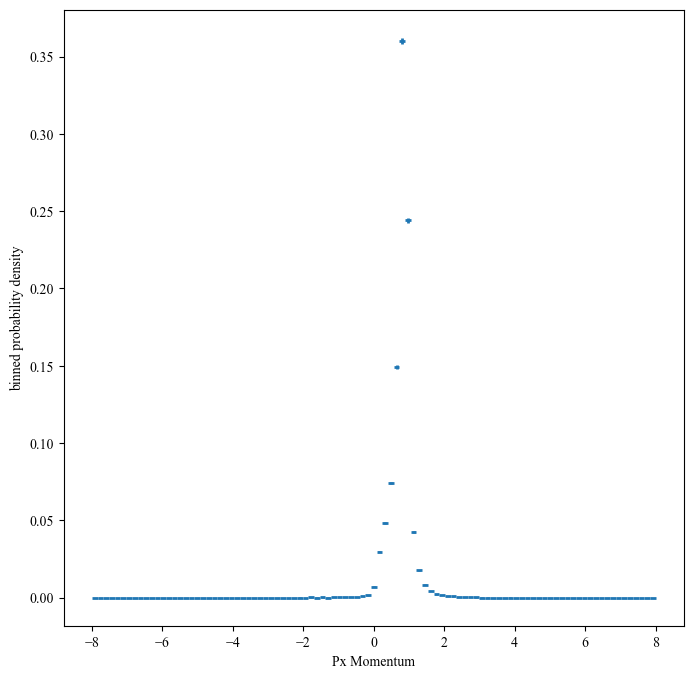

In [18]:
binneddensity(bhads_fractions_px, fixedbinning(-8,8,100), xlabel = "Px Momentum")

In [19]:
binneddensity(tracks_original[:,0,0], fixedbinning(-10000,10000,100), xlabel = "SecondaryVertex")

NameError: name 'tracks_original' is not defined

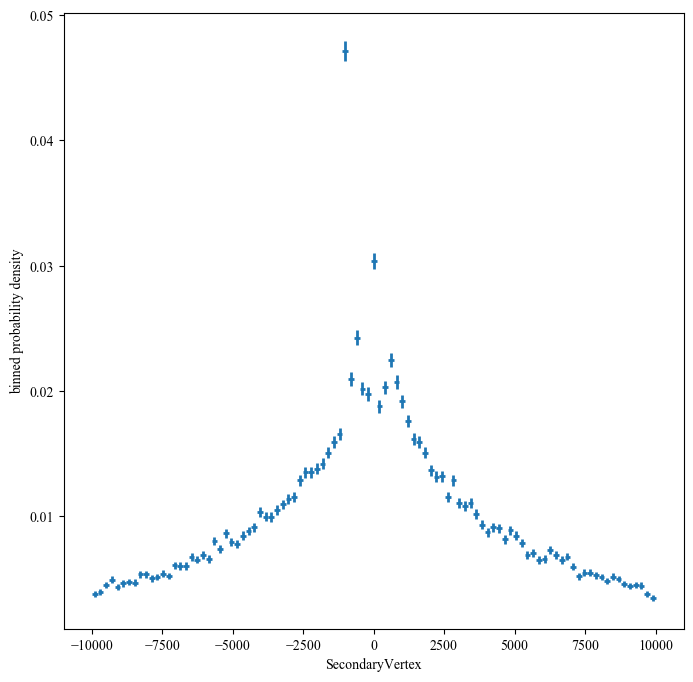

In [ ]:
binneddensity(tracks[:,0,0], fixedbinning(-10000,10000,100), xlabel = "SecondaryVertex")

In [20]:
#Creates an approximate track momentum and 4 momentum for the network to use.
Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)
Tracks_4_Momentum = np.stack([Tracks_Momentum, tracks[:,:,0], tracks[:,:,1], tracks[:,:,2]], axis = -1)
print(Tracks_4_Momentum.shape)

(96659, 32, 4)


/tmp/ipykernel_29887/1231091614.py:2: RuntimeWarning: invalid value encountered in sqrt
  Tracks_Momentum = np.sqrt(tracks[:, : ,0]**2 + tracks[:,:,1]**2 + tracks[:,:,2]**2)


In [21]:
#Creates a very approximate track mass for the network to use.
Tracks_Invariant_Mass = np.sqrt((np.sum(Tracks_4_Momentum, axis = 1) * np.sum(Tracks_4_Momentum, axis = 1)).sum(axis = -1))
print(Tracks_Invariant_Mass.shape)

(96659,)


In [ ]:
#Maskes the padding from the secondary vertex displacement data
Secondary_Displacement = np.ma.masked_values(Secondary_Displacement,-999)

NameError: name 'Secondary_Displacement' is not defined

In [ ]:
np.min(Secondary_Displacement), np.max(Secondary_Displacement), np.quantile(Secondary_Displacement, 0.75)

(0.0, 115.98360443115234, 1.480406939983368)

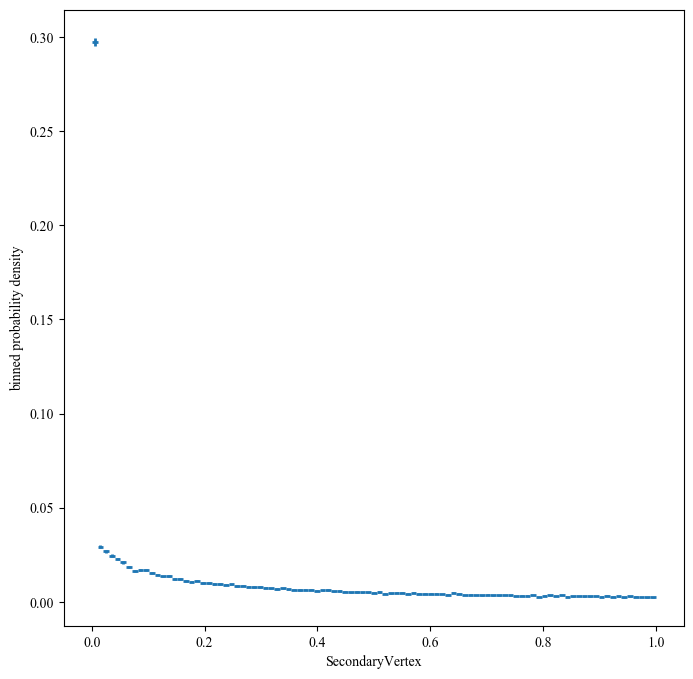

In [ ]:
#Testing the secondary vertex displacement variation check it has been loaded in correctly.
binneddensity(Secondary_Displacement, fixedbinning(0,1,100), xlabel = "SecondaryVertex")

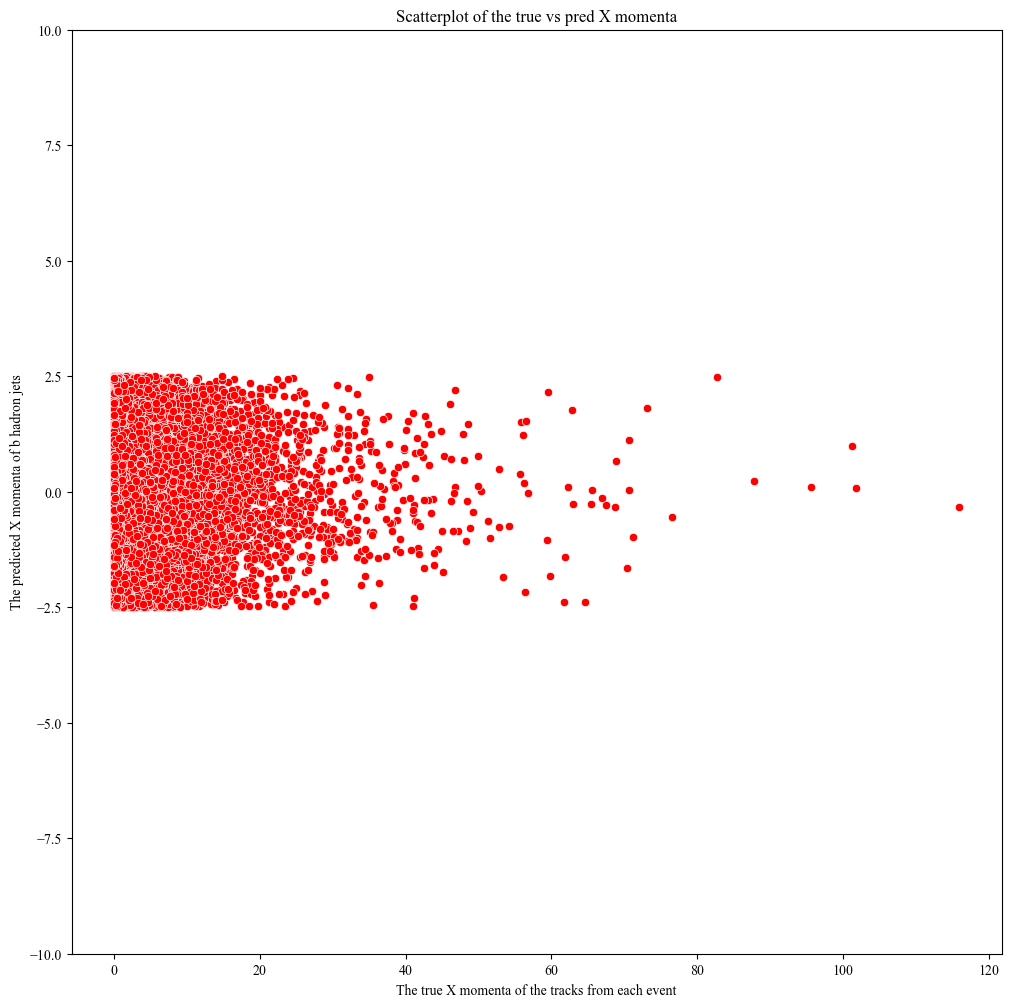

In [ ]:
#Testing to see whether any linear correlation exists between the track features and secondary displacement vertex
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = tracks[:,1,4],
    x = Secondary_Displacement,
    color = "red"
)
ax.set_ylim(-10,10)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
fig.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/ScatterplotXgboost")

In [ ]:
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores")
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [22]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature

b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_tracks = np.sum(tracks[:,:,0], axis = 1)
sum_py_tracks = np.sum(tracks[:,:,1], axis = 1)
sum_pz_tracks = np.sum(tracks[:,:,2], axis = 1)
sum_pt_tracks = np.sum(tracks[:,:,3], axis = 1)
print(sum_pt_tracks.shape)

sum_px_tracks_RSE = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1))
sum_py_tracks_RSE= np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1))
sum_pz_tracks_RSE = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1))
sum_pt_tracks_RSE = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1))
print(sum_pt_tracks_RSE.shape)

RSM_scaled_px = sum_px_tracks_RSE/sum_px_tracks
RSM_scaled_py = sum_py_tracks_RSE/sum_py_tracks
RSM_scaled_pz = sum_pz_tracks_RSE/sum_pz_tracks
RSM_scaled_pt = sum_pt_tracks_RSE/sum_pt_tracks
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(tracks[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(tracks[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(tracks[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(tracks[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_tracks = np.log(abs(tracks[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_tracks = np.log(abs(tracks[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_tracks = np.log(abs(tracks[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_tracks = np.log(abs(tracks[:,:,3]/b_jets[:,np.newaxis,3]))
Log_tracks = np.stack([Log_px_tracks, Log_py_tracks, Log_pz_tracks, Log_pt_tracks], axis = -1)

Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

tracks_fractions_px = tracks[:,:,0]/b_jets[:,np.newaxis,0]
tracks_fractions_py = tracks[:,:,1]/b_jets[:,np.newaxis,1]
tracks_fractions_pz = tracks[:,:,2]/b_jets[:,np.newaxis,2]
tracks_fractions_pt = tracks[:,:,3]/b_jets[:,np.newaxis,3]
print(tracks_fractions_pt.shape)
Track_fractions = np.stack([tracks_fractions_px,tracks_fractions_py, tracks_fractions_pz], axis = -1)
print(Track_fractions.shape)

print(Track_fractions.shape)
print(tracks[0,0,0]/b_jets[0,0])
print(np.mean(Track_fractions),np.std(Track_fractions))

print("hey")
Tracks_projection = ((tracks[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(Tracks_projection.shape)
Track_Momenta = np.stack([sum_px_tracks, sum_py_tracks, sum_pz_tracks], axis = -1)
print(Track_Momenta.shape)
Sum_Tracks_projection = ((Track_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_Tracks_projection.shape)

b_jet_energy_ratio_px = sum_px_tracks/b_jets_energy
b_jet_energy_ratio_py = sum_py_tracks/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_tracks/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_tracks/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))
b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_tracks, sum_py_tracks, sum_pz_tracks, sum_pt_tracks, sum_px_tracks_RSE, sum_py_tracks_RSE, sum_pz_tracks_RSE, sum_pt_tracks_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6,bhads_pt/1e6, bhads_eta, bhads_phi, bhads_energy/1e6, bhads_fractions_pt, bhads_projection], axis = -1)

(96659,)
(96659,) (96659, 1)
(96659,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-4195.466731248074 618.1237235802715
Hello
(96659,)


/tmp/ipykernel_29887/854848967.py:20: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(96659,)
(96659,)
(96659,)


/tmp/ipykernel_29887/854848967.py:67: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_29887/854848967.py:67: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_tracks/b_jets[:,0])
/tmp/ipykernel_29887/854848967.py:68: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_29887/854848967.py:68: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_tracks/b_jets[:,1])
/tmp/ipykernel_29887/854848967.py:69: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_29887/854848967.py:69: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_tracks/b_jets[:,2])
/tmp/ipykernel_29887/854848967.py:70: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_tracks/b_jets[:,3])


(96659,)
(96659, 32)
(96659, 32, 3)
(96659, 32, 3)
0.14894195156291137
-670.9594413217917 469.1820966775337
hey
(96659, 32)
(96659, 3)
(96659,)
(96659,)
(96659,)
79564.74
()
(96659,)
(96659,)
end
215380.48 189104.06


In [ ]:
print(np.shape(bhads_fractions_pt))

(96067,)


In [ ]:
#Masking out the padding added to some of the bhadron targets
bhads_targets = np.ma.masked_values(bhads_targets, -999)

In [ ]:
np.min(bhads_targets), np.max(bhads_targets)

(-34465.39587820514, 618.1237235802715)

In [23]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
Tracks_input = np.concatenate([tracks, Track_fractions, Log_tracks], axis = -1)
print(Tracks_input.shape)

(96659, 32, 18)


In [24]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
b_jets_input = np.concatenate([b_jets, Tracks_projection, Sum_Tracks_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(96659, 71)


In [ ]:
make_mi_scores(b_jets_input, Secondary_Displacement)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
make_mi_scores(Tracks_input.reshape(len(Tracks_input),-1), Secondary_Displacement)

KeyboardInterrupt: 

In [25]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({511: 20748, -521: 20663, -511: 20551, 521: 20534, 531: 4693, -531: 4656, 5122: 1893, -5122: 1848, 5132: 278, 5232: 267, -5132: 261, -5232: 250, 5332: 6, -5332: 6, -541: 4, 555: 1})


In [26]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    else:
        element = 2
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(96659, 1)
Counter({1.0: 41299, 0.0: 41197, 2.0: 14163})
(96659, 3)


In [39]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
Tracks_input_clean = np.delete(Tracks_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0)
onehot = np.delete(onehot, mask, axis = 0)  
print(Tracks_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(96657, 71)
(96657, 32, 18) (96657, 71) (96657,) (96657, 9)


In [28]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(Tracks_input_clean)
Scaled_tracks = np.reshape(Tracks_input_clean, newshape=(-1,Num_features))
tracks_scaled = Scaler_tracks.fit_transform(Scaled_tracks)
Tracks_input_scaled = np.reshape(tracks_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(Tracks_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(96657, 32, 18)
(96657, 71)
(96657, 9)
[-6.71877590e-05 -3.34489880e-05 -7.65972120e-05  8.22205499e-02
 -6.61961181e-04  2.30489625e-03  1.62377512e-01  7.83897821e-01
  7.81662893e-01] [0.06544803 0.06529751 0.19986421 0.04227287 1.22645971 1.81510578
 0.14884433 0.24660007 0.2463406 ]


In [29]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({511: 20748, -521: 20663, -511: 20551, 521: 20534, 531: 4693, -531: 4656, 5122: 1893, -5122: 1848, 5132: 278, 5232: 267, -5132: 261, -5232: 250, 5332: 6, -5332: 6, -541: 4, 555: 1})


In [30]:
from collections import Counter
counter = Counter(bhads_m_clean)
print(counter)

Counter({5279.580078125: 41299, 5279.169921875: 28343, 5279.25: 12852, 5366.77001953125: 9349, 5619.39990234375: 2288, 5620.2001953125: 1453, 5791.10009765625: 440, 5788.0: 433, 5790.5: 183, 6070.0: 12, 6277.0: 4, 9912.2001953125: 1})


In [31]:
# Builds the deep neural network
track_layers = [64 for x in range(2)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [64 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.0001)

[18, 64, 64]
3


2023-02-23 21:42:52.456385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-23 21:42:52.456429: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-23 21:42:52.456481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-02-23 21:42:52.458709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    else:
        element = 2
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(96659, 1)
Counter({1.0: 41299, 0.0: 41197, 2.0: 14163})
(96659, 3)


In [33]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [34]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 18)    342         ['input_3[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_residual_unit  (None, None, 18)    720         ['time_distributed[1][0]']       
 s (TimeDistributedResidualUnit                                                                   
 s)                                                                                           

In [35]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 25*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [36]:
history  = DeepSetProjector.fit(
    (Tracks_input_scaled,b_jets_input_scaled), y = {"MultivariateLoss":bhads_targets_clean, "MassOutput":onehot},
    validation_split = 0.3,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
1058/1058 [==============================] - 32s 22ms/step - loss: 19.0352 - MultivariateLoss_loss: 1.9053 - MassOutput_loss: 1.0185 - MultivariateLoss_Mean_Squared_Error: 0.6303 - MassOutput_Mean_Squared_Error: 0.2067 - val_loss: 13.4049 - val_MultivariateLoss_loss: -3.0337 - val_MassOutput_loss: 1.0128 - val_MultivariateLoss_Mean_Squared_Error: 0.4022 - val_MassOutput_Mean_Squared_Error: 0.2056 - lr: 5.0000e-04
Epoch 2/1000
1058/1058 [==============================] - 22s 21ms/step - loss: 8.1473 - MultivariateLoss_loss: -7.5104 - MassOutput_loss: 1.0096 - MultivariateLoss_Mean_Squared_Error: 0.3466 - MassOutput_Mean_Squared_Error: 0.2051 - val_loss: 7.3875 - val_MultivariateLoss_loss: -7.4784 - val_MassOutput_loss:

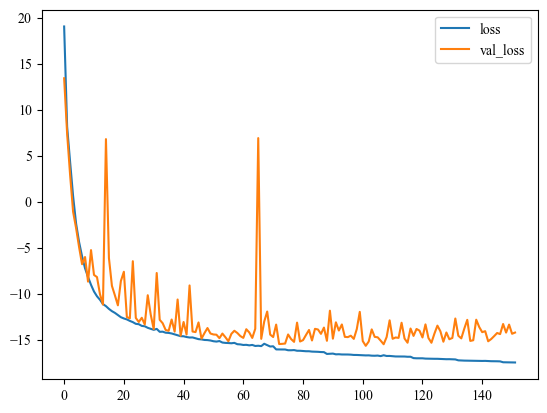

In [37]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/historyResidualNeuralNetwork.csv')
DeepSetProjector.save_weights("/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&BiasesFix.ckpt")

In [40]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 10s - loss: -1.6440e+01 - MultivariateLoss_loss: -1.8054e+01 - MassOutput_loss: 1.0101 - MultivariateLoss_Mean_Squared_Error: 0.0236 - MassOutput_Mean_Squared_Error: 0.2052 - 10s/epoch - 3ms/step
The Loaded DeepNet has loss:  [-16.440420150756836, -18.05400848388672, 1.0100620985031128, 0.023558467626571655, 0.20516695082187653]


In [ ]:
bhads_targets_clean.shape

(96657, 16)

In [ ]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 9s - loss: 19316830208.0000 - MultivariateLoss_loss: 19316830208.0000 - MassOutput_loss: 0.2550 - MultivariateLoss_Mean_Squared_Error: 1163.9373 - MassOutput_Mean_Squared_Error: 0.1567 - 9s/epoch - 3ms/step
The Loaded DeepNet has loss:  [19316830208.0, 19316830208.0, 0.25499260425567627, 1163.937255859375, 0.1567482203245163]


In [41]:
predictions = DeepSetProjector.predict((Tracks_input_scaled, b_jets_input_scaled))

3021/3021 [==============================] - 7s 2ms/step


In [81]:
Predictions = np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [82]:
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [83]:
Predictions.shape

(96657, 54)

In [90]:
n_targets = np.shape(Standardized_Bhads_targets)[1]

In [91]:
n_targets*(n_targets-1)/2

36.0

In [84]:
lister = []
index = 0
predictions_x = Predictions[:,:np.shape(Standardized_Bhads_targets)[1]]
predictions_X = predictions_x
"""
for bhads_features in range(np.shape(predictions_x)[1]):
    Predictions_temp = predictions_x[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_X = np.concatenate(lister, axis = 1)
print(Predictions_X)"""

'\nfor bhads_features in range(np.shape(predictions_x)[1]):\n    Predictions_temp = predictions_x[:, bhads_features]\n    Predictions_temp = (Predictions_temp*stds[index]) + means[index]\n    Predictions_temp = Predictions_temp.reshape(-1,1)\n    lister.append(Predictions_temp)\n    index+=1\nPredictions_X = np.concatenate(lister, axis = 1)\nprint(Predictions_X)'

In [116]:
predictions_x_uncertainty = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:2*np.shape(Standardized_Bhads_targets)[1]]

In [87]:
Predictions.shape
variances = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:2*np.shape(Standardized_Bhads_targets)[1]].shape
covariances = Predictions[:,:2*np.shape(Standardized_Bhads_targets)[1]].shape

In [88]:
print(variances,covariances)

(96657, 9) (96657, 18)


In [96]:
from HffragDeepSetsProjectionMultivariate import generate_triu
lister = []
index = 0
predictions_x_uncertainty = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:]
predictions_uncertainty = np.array(list(map(lambda x: generate_triu(x, 9), Predictions)))
covariance_matrix = np.array([x @ x.T for x in predictions_uncertainty])
"""
print(predictions_x_uncertainty)
for bhads_features in range(np.shape(predictions_x_uncertainty)[1]):
    Predictions_temp = predictions_x_uncertainty[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds[index]) + means[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_Uncertainty = np.concatenate(lister, axis = 1)"""
Predictions_Uncertainty = np.diag(covariance_matrix)
print(Predictions_Uncertainty)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2800, in while_loop
    return result  File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2756, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 496, in compute
    return (i + 1, tas)  File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow/python/ops/map_fn.py", line 494, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/home/physics/phujdj/ana

ValueError: Input must be 1- or 2-d.

In [117]:
Predictions_Uncertainty = predictions_x_uncertainty

In [114]:
np.min(Predictions_Uncertainty)

-3.0420172

In [99]:
Predictions_Uncertainty = np.array(list(map(lambda x: np.diag(x), covariance_matrix)))

(96657, 9, 9)

In [118]:
Error_px_unscaled = (bhads_targets_clean[:,0] - predictions_X[:,0])*1e6
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_clean[:,0]*1e6)
Pull_px = Error_px_unscaled/(Predictions_Uncertainty[:,0]*1e6)

In [119]:
Error_py_unscaled = (bhads_targets_clean[:,1] - predictions_X[:,1])*1e6
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_clean[:,1]*1e6)
Pull_py = Error_py_unscaled/(Predictions_Uncertainty[:,1]*1e6)

In [120]:
Error_pz_unscaled = (bhads_targets_clean[:,2] - predictions_X[:,2])*1e6
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_clean[:,2]*1e6)
Pull_pz = Error_pz_unscaled/(Predictions_Uncertainty[:,2]*1e6)

In [121]:
Error_pt_unscaled = (bhads_targets_clean[:,3] - predictions_X[:,3])*1e6
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,3]*1e6)
Pull_pt = Error_pt_unscaled/(Predictions_Uncertainty[:,3]*1e6)

In [122]:
Error_eta_unscaled = bhads_targets_clean[:,4] - predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_clean[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [123]:
Error_phi_unscaled = bhads_targets_clean[:,5] - predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [124]:
Error_energy_unscaled = (bhads_targets_clean[:,6] - predictions_X[:,6])*1e6
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,6]*1e6)
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,6]*1e6)

In [125]:
Error_ptfraction_unscaled = bhads_targets_clean[:,7] - predictions_X[:,7]
Pull_ptfraction_unscaled = Error_ptfraction_unscaled/np.std(bhads_targets_clean[:,7])
Pull_ptfraction = Error_ptfraction_unscaled/Predictions_Uncertainty[:,7]

In [126]:
Error_projection_unscaled = bhads_targets_clean[:,8] - predictions_X[:,8]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_clean[:,8])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,8]

In [127]:
Error_pxfraction_unscaled = bhads_targets_clean[:,6] - predictions_X[:,6]
Pull_pxfraction_unscaled = Error_pxfraction_unscaled/np.std(bhads_targets_clean[:,6])
Pull_pxfraction = Error_pxfraction_unscaled/Predictions_Uncertainty[:,6]

In [128]:
Error_pyfraction_unscaled = bhads_targets_clean[:,7] - predictions_X[:,7]
Pull_pyfraction_unscaled = Error_pyfraction_unscaled/np.std(bhads_targets_clean[:,7])
Pull_pyfraction = Error_pyfraction_unscaled/Predictions_Uncertainty[:,7]

In [129]:
Error_pzfraction_unscaled = bhads_targets_clean[:,8] - predictions_X[:,8]
Pull_pzfraction_unscaled = Error_pzfraction_unscaled/np.std(bhads_targets_clean[:,8])
Pull_pzfraction = Error_pzfraction_unscaled/Predictions_Uncertainty[:,8]

In [130]:
Error_energy_unscaled = (bhads_targets_clean[:,9] - predictions_X[:,9])*1e6
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,9]*1e6)
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,9]*1e6)

IndexError: index 9 is out of bounds for axis 1 with size 9

In [ ]:
Error_projection_unscaled = bhads_targets_clean[:,12] - predictions_X[:,12]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_clean[:,12])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,12]

In [ ]:
Error_mass_unscaled = (bhads_targets_clean[:,13] - predictions_X[:, 13])*1e3
Pull_mass_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,13]*1e3)
Pull_mass = Error_energy_unscaled/(Predictions_Uncertainty[:,13]*1e3)

In [ ]:
Error_Secondary_Displacement_unscaled = (bhads_targets_clean[:,14] - predictions_X[:, 14])*1e4
Pull_Secondary_Displacement_unscaled = Error_Secondary_Displacement_unscaled/np.std(bhads_targets_clean[:,14]*1e4)
Pull_Secondary_Displacement = Error_Secondary_Displacement_unscaled/(Predictions_Uncertainty[:,14]*1e4)

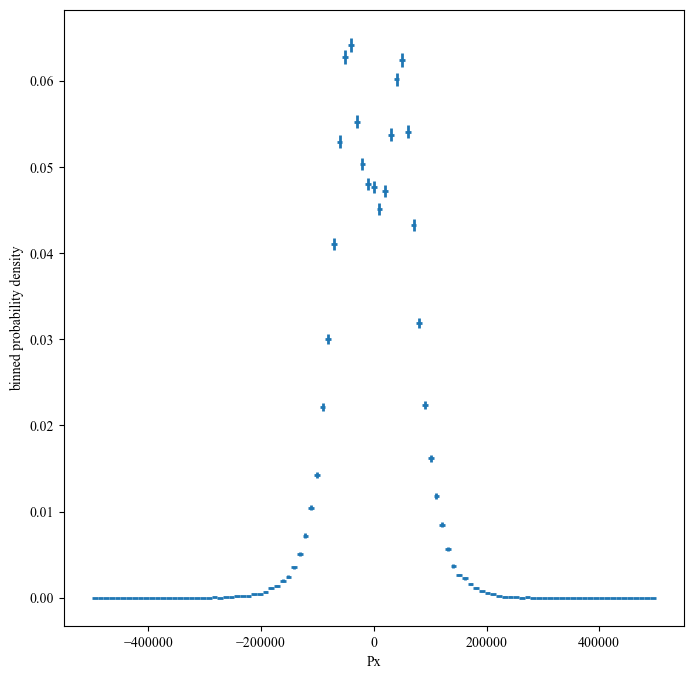

In [110]:
binneddensity(predictions_X[:,0]*1e6,fixedbinning(-5e5,5e5,100), xlabel = "Px")

In [52]:
predictions_X.shape

(96657, 9)

-847.6260597636433
15776.156195233429


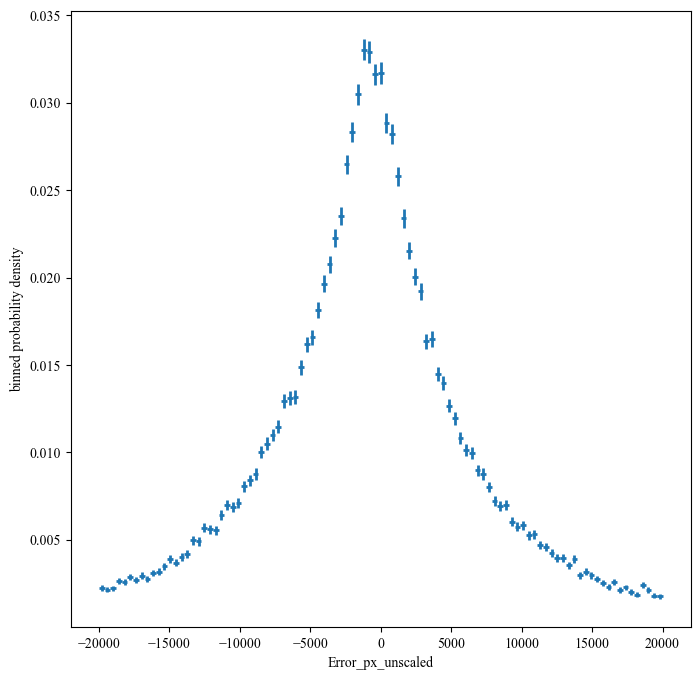

In [131]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

-0.09081748909046701
0.9395694323157691


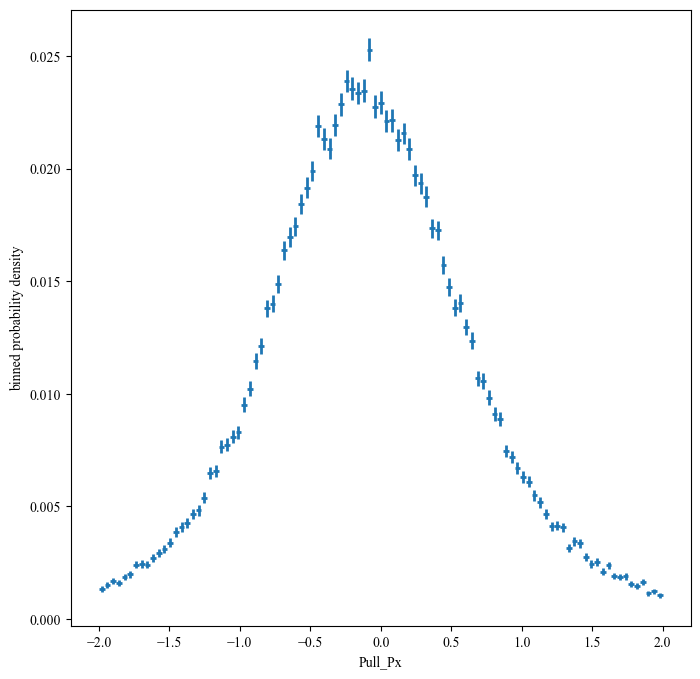

In [132]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

568.9835378569105
15704.473274958676


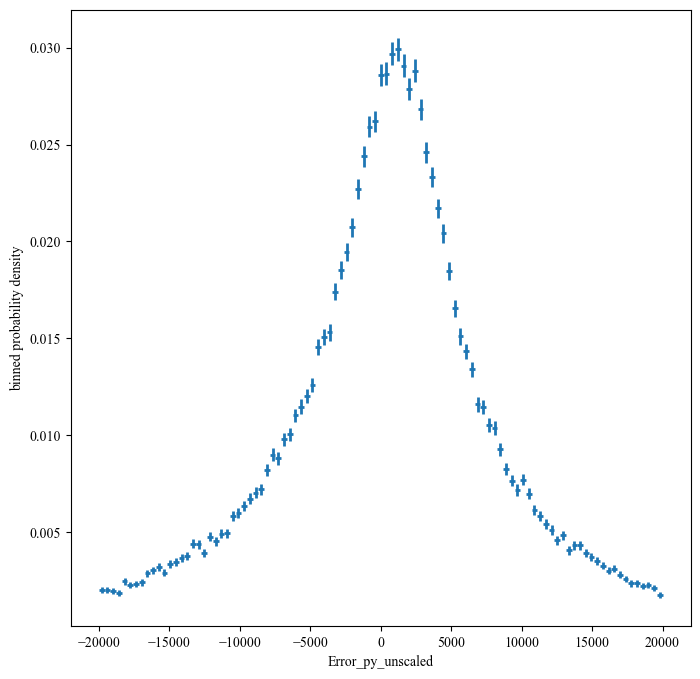

In [133]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

0.10109161837997699
0.980849700505931


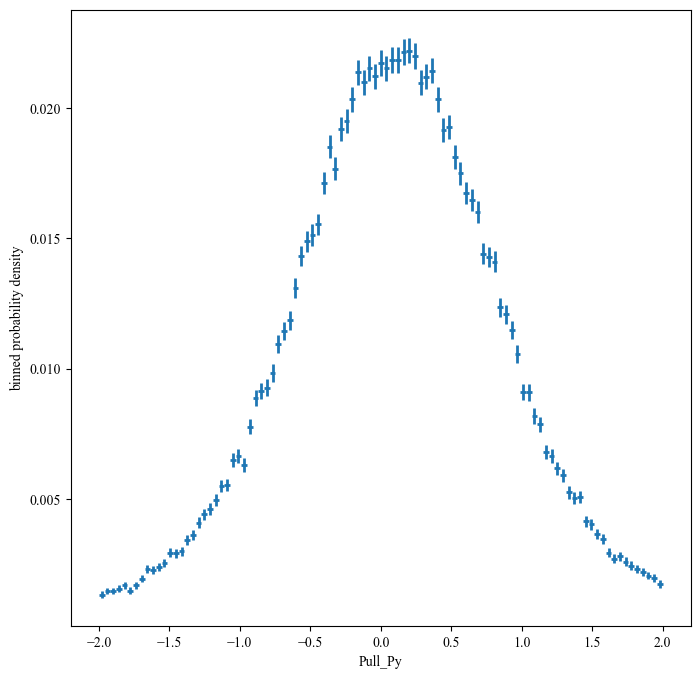

In [134]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

-467.6347563515357
48065.269295887134


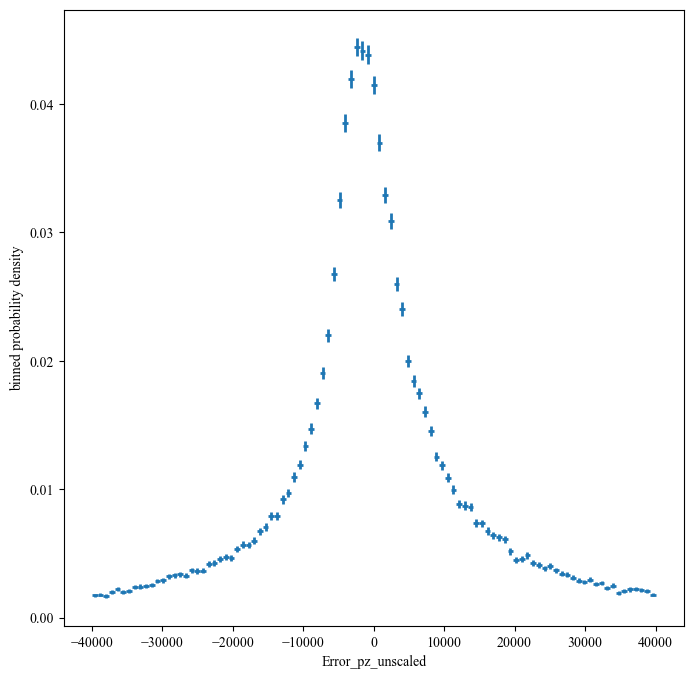

In [135]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

-0.06870087083570292
0.8101275783722262


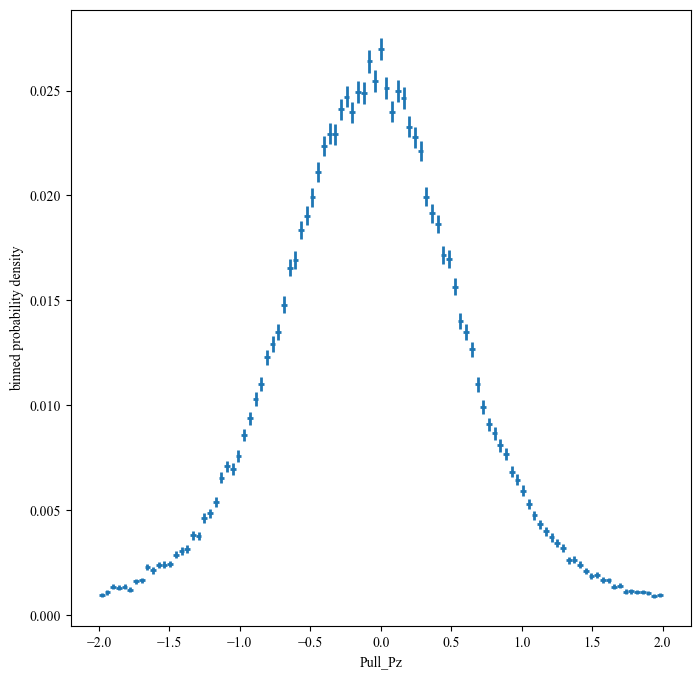

In [137]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

0.0028352077791826227
0.177532850948063


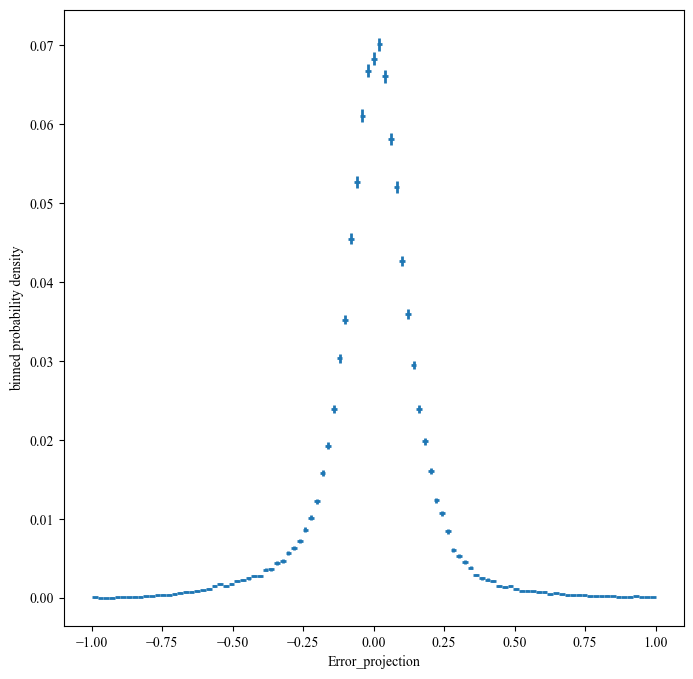

In [138]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

0.010733823716242456
1.0281105021550605


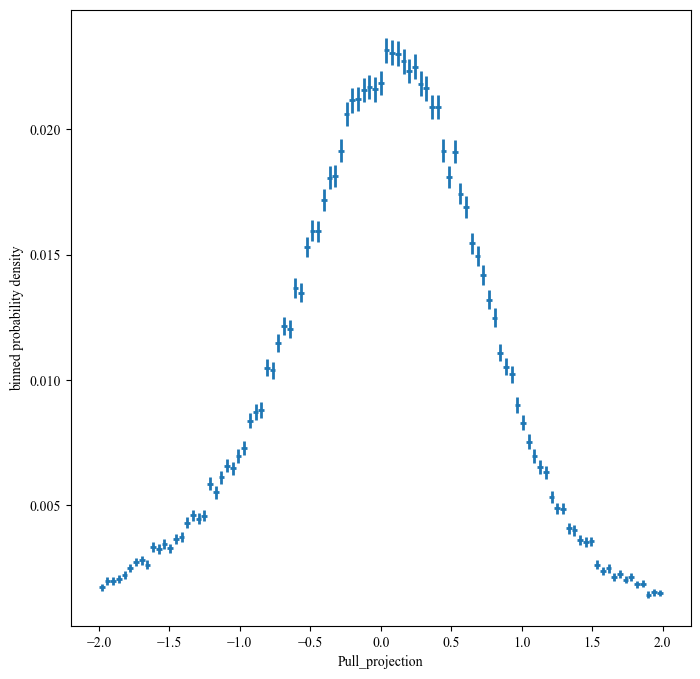

In [139]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-2,2,100),xlabel = "Pull_projection")

0.0005457974411421137
0.17823985419329347


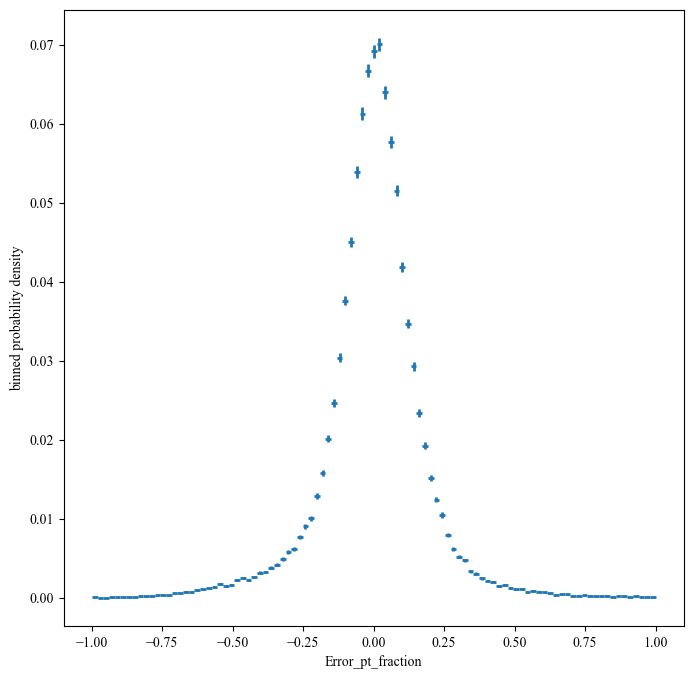

In [141]:
print(np.mean(Error_ptfraction_unscaled))
print(np.std(Error_ptfraction_unscaled))
binneddensity(Error_ptfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pt_fraction")

0.002213289913191522
0.7227891552390507


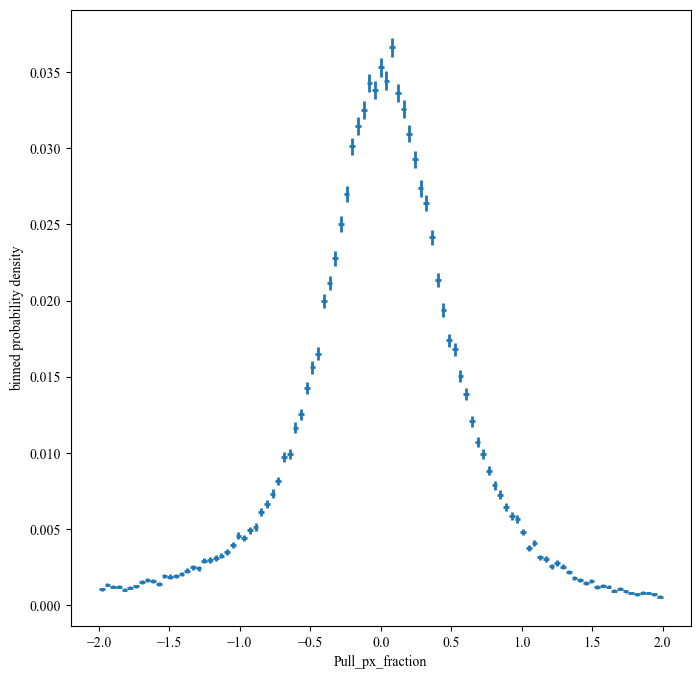

In [142]:
print(np.mean(Pull_ptfraction_unscaled))
print(np.std(Pull_ptfraction_unscaled))
binneddensity(Pull_ptfraction_unscaled, fixedbinning(-2,2,100),xlabel = "Pull_px_fraction")

438.5783299080232
51774.11247030242


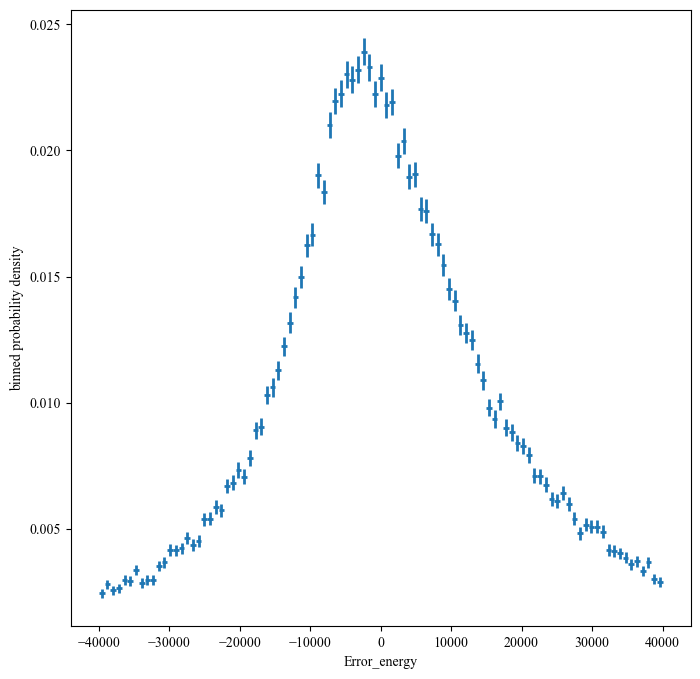

In [144]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_energy")

0.002946557146507326
0.34784067223621573


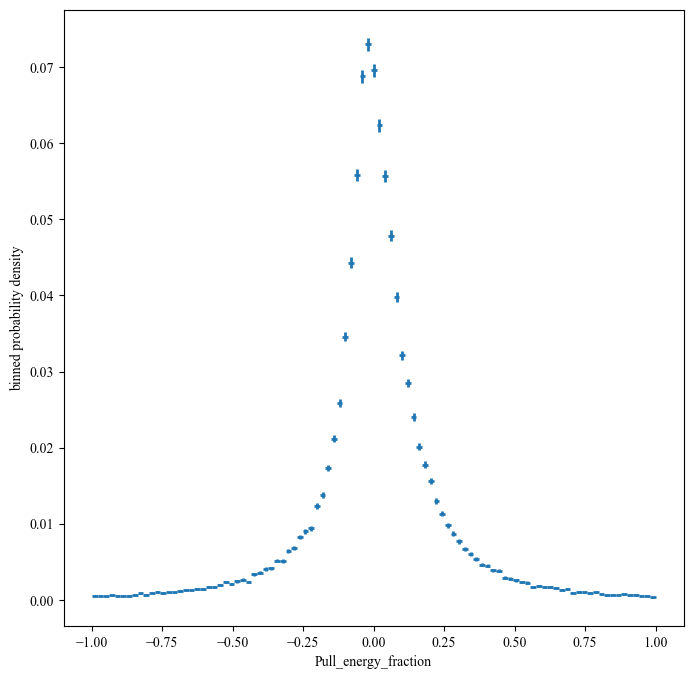

In [145]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

-1310.061742014185
21935.55932975622


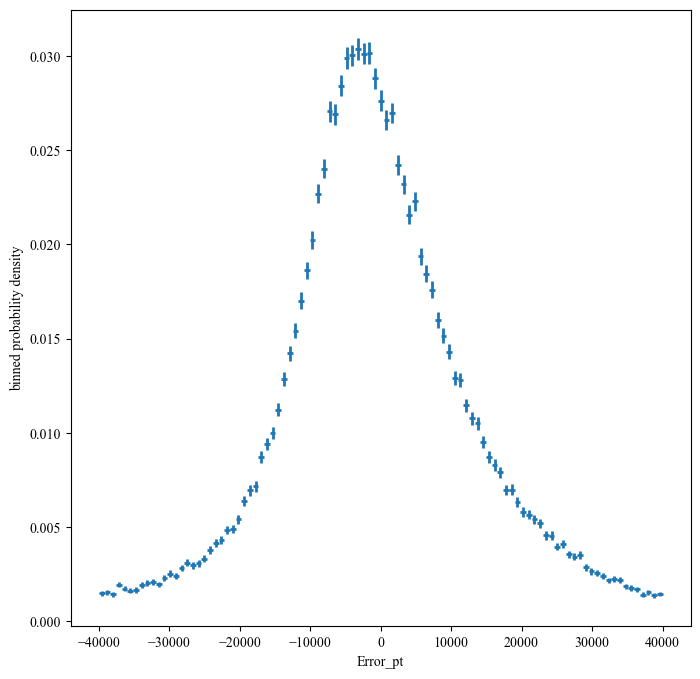

In [146]:
print(np.mean(Error_pt_unscaled))
print(np.std(Error_pt_unscaled))
binneddensity(Error_pt_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pt")

-0.12601948535746277
0.9908027804746983


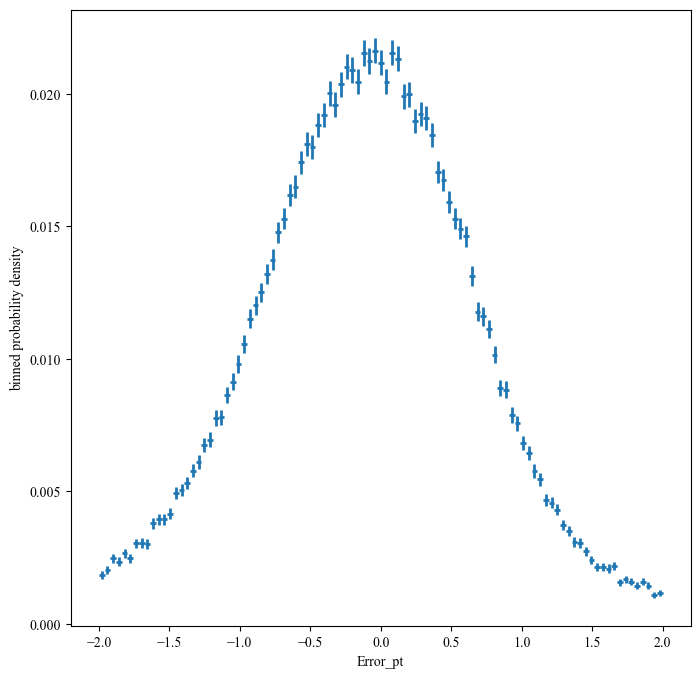

In [147]:
print(np.mean(Pull_pt))
print(np.std(Pull_pt))
binneddensity(Pull_pt, fixedbinning(-2,2,100),xlabel = "Error_pt")

-0.0015881268605568773
0.06068557115609205


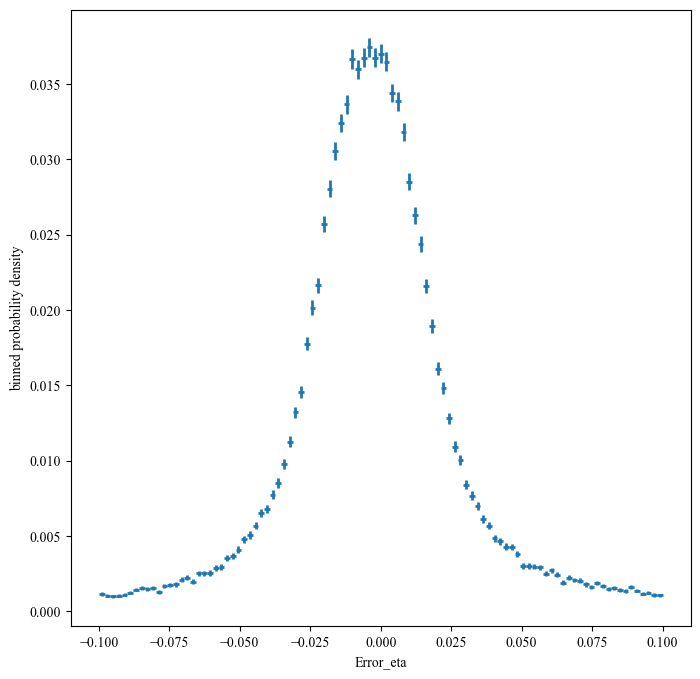

In [150]:
print(np.mean(Error_eta_unscaled))
print(np.std(Error_eta_unscaled))
binneddensity(Error_eta_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_eta")

-0.11752793216520215
1.1414462561335454


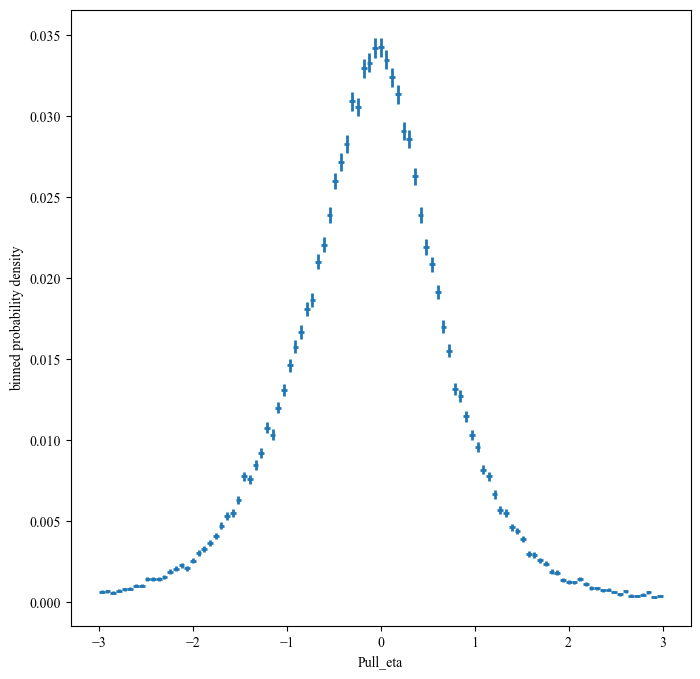

In [151]:
print(np.mean(Pull_eta))
print(np.std(Pull_eta))
binneddensity(Pull_eta, fixedbinning(-3,3,100),xlabel = "Pull_eta")

-0.00321252129919131
0.37291317650998707


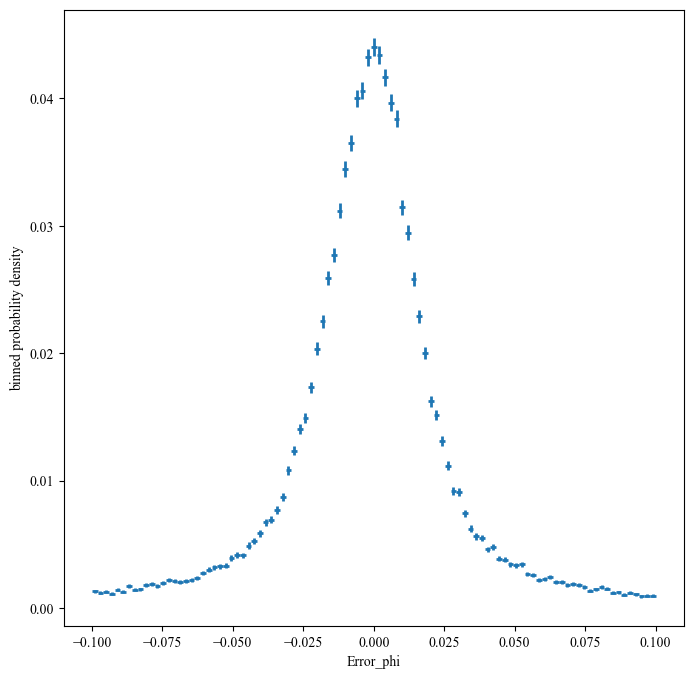

In [76]:
print(np.mean(Error_phi_unscaled))
print(np.std(Error_phi_unscaled))
binneddensity(Error_phi_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_phi")

-0.031185901705238644
1.0607709703228945


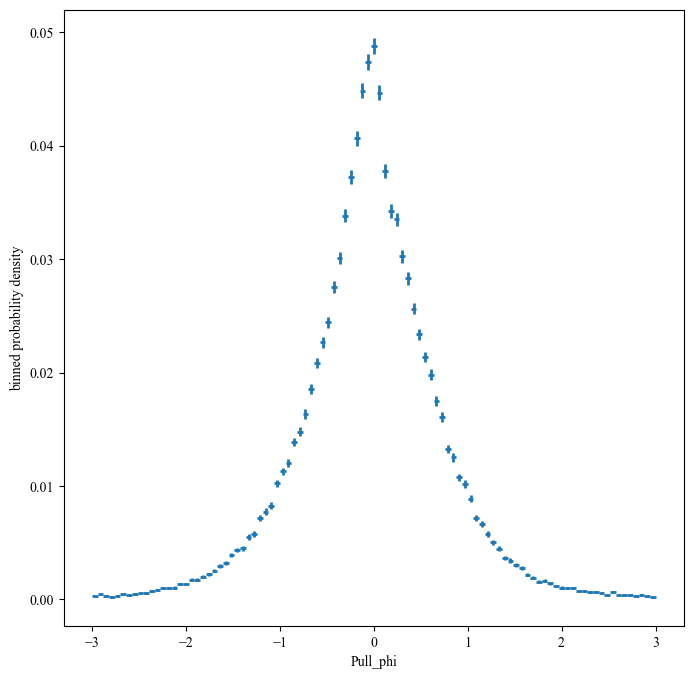

In [152]:
print(np.mean(Pull_phi))
print(np.std(Pull_phi))
binneddensity(Pull_phi, fixedbinning(-3,3,100),xlabel = "Pull_phi")

-303.9391517639167
877.6634874611916


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


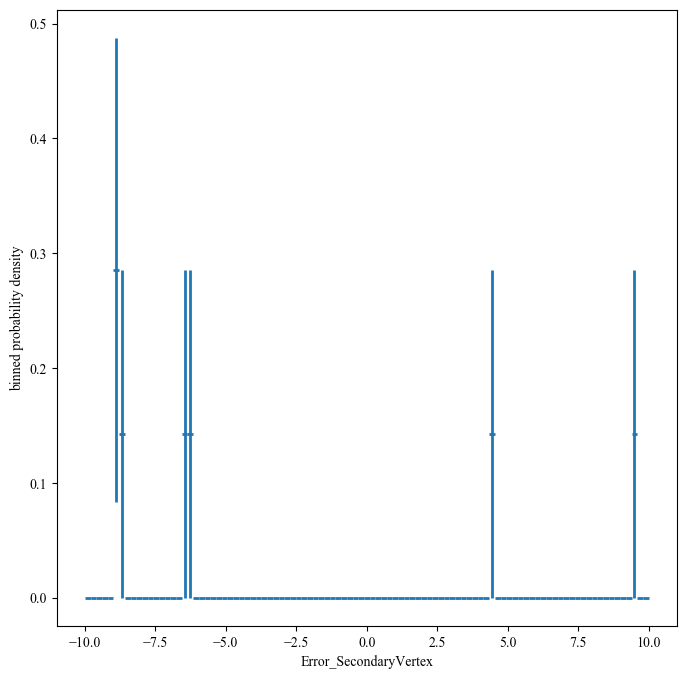

In [ ]:
print(np.median(Error_Secondary_Displacement_unscaled))
print(np.std(Error_Secondary_Displacement_unscaled))
binneddensity(Error_Secondary_Displacement_unscaled, fixedbinning(-10,10,100),xlabel = "Error_SecondaryVertex")

-0.3642392812484506
0.9992503227597264


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


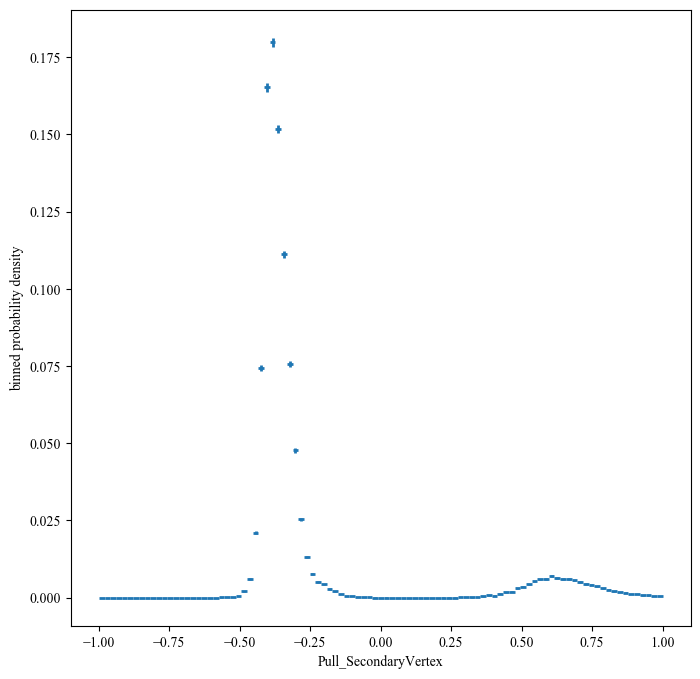

In [ ]:
print(np.median(Pull_Secondary_Displacement))
print(np.std(Pull_Secondary_Displacement))
binneddensity(Pull_Secondary_Displacement, fixedbinning(-1,1,100),xlabel = "Pull_SecondaryVertex")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X momenta of b hadron jets')

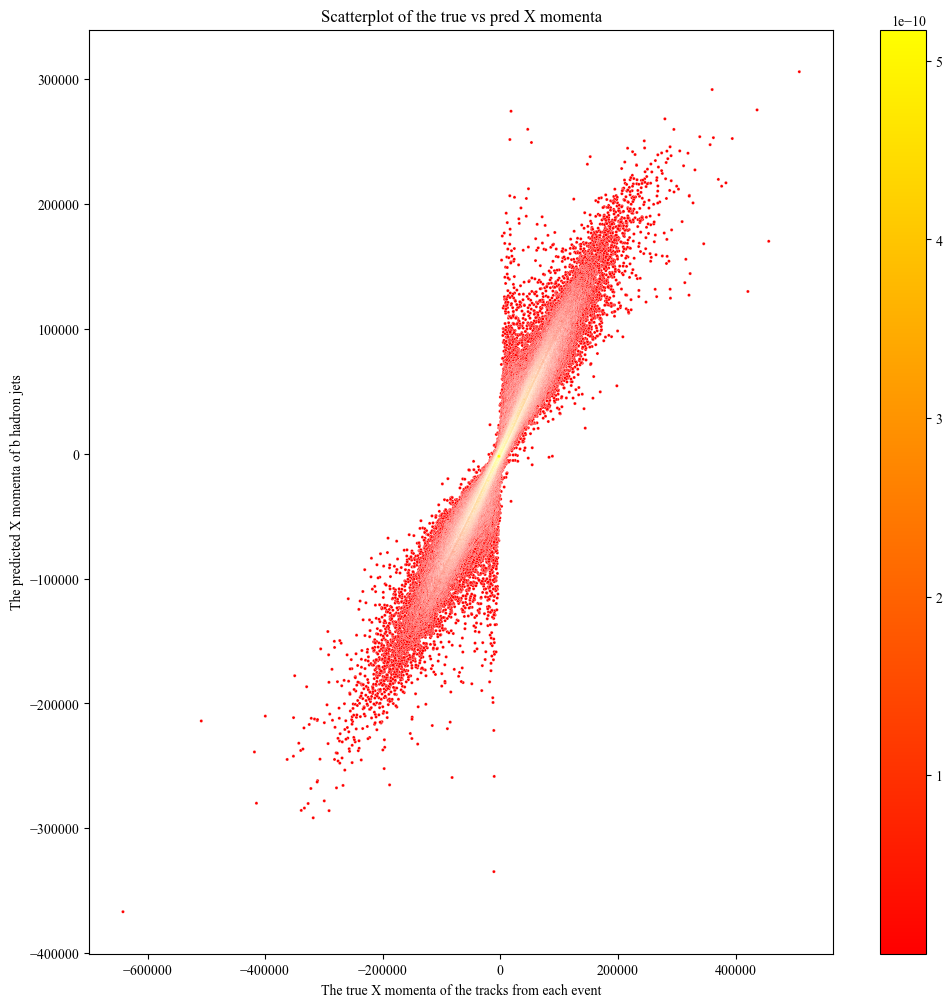

In [153]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,0]*1e6
y = predictions_X[:,0]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
[bhads[:,0],bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m, Secondary_Displacement]

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

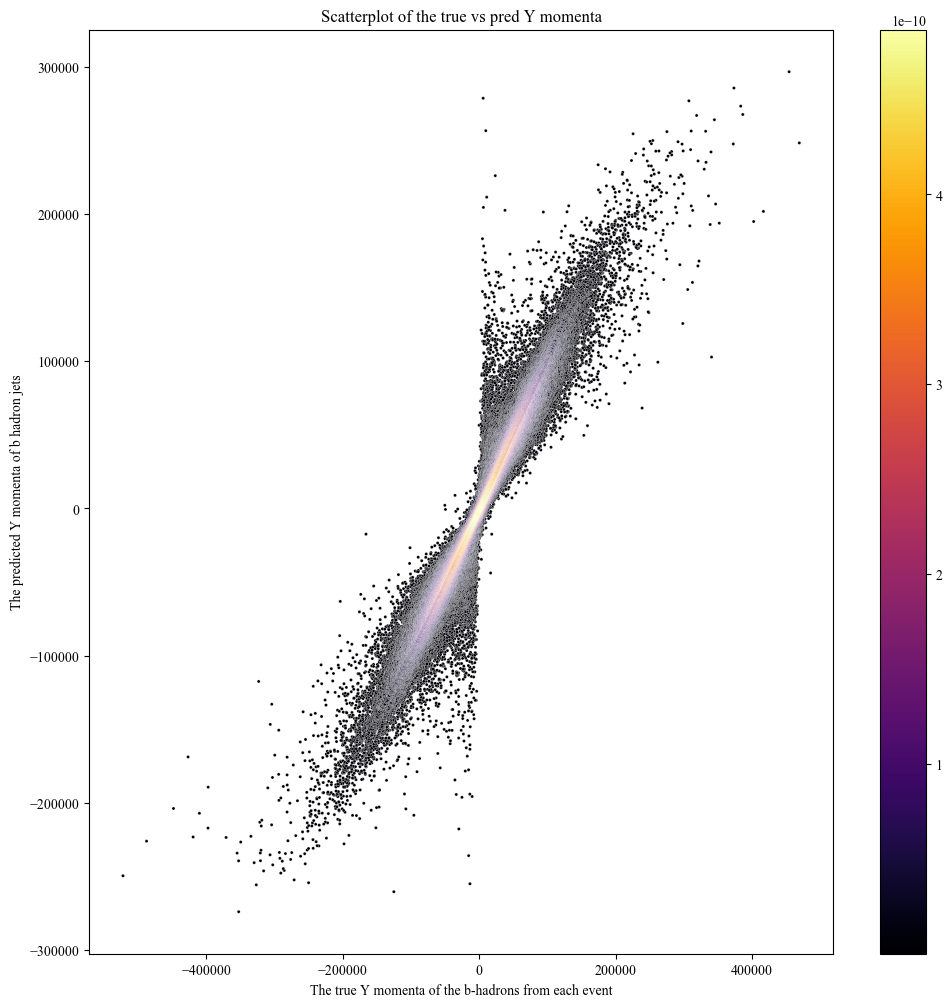

In [154]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,1]*1e6
y = predictions_X[:,1]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

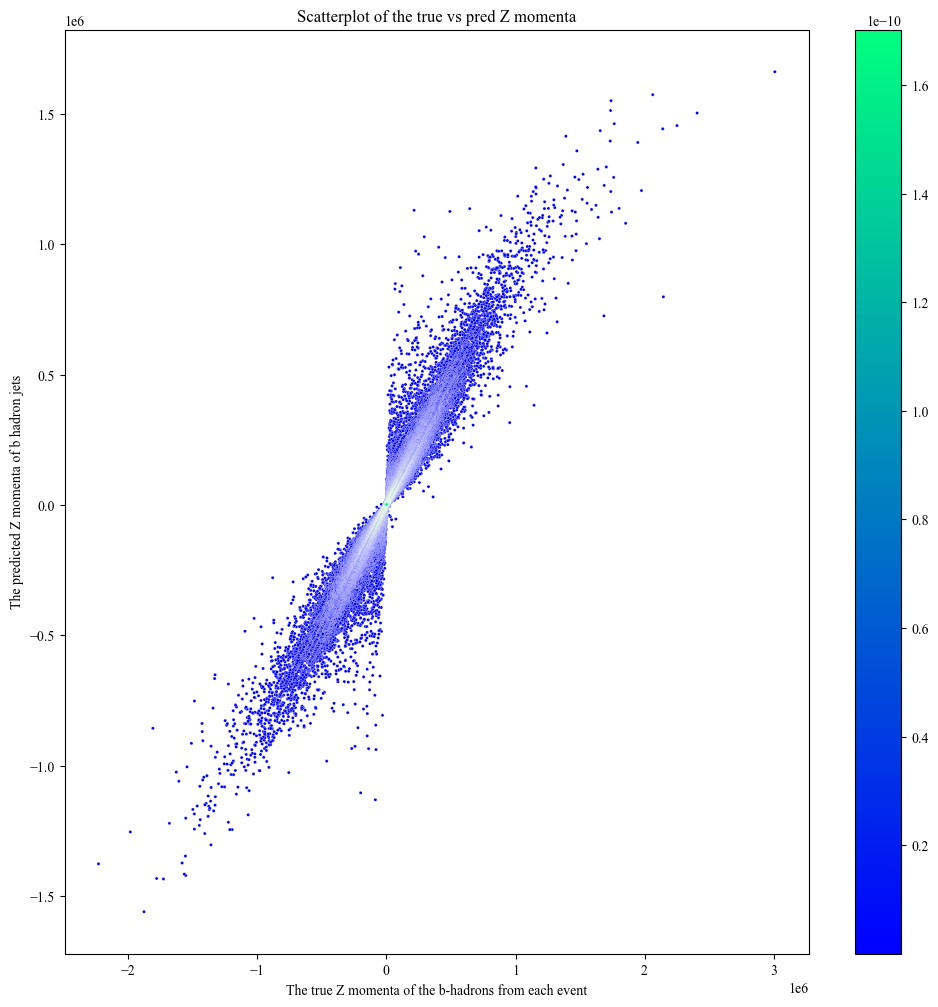

In [155]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,2]*1e6
y = predictions_X[:,2]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted transverse momenta of b hadron jets')

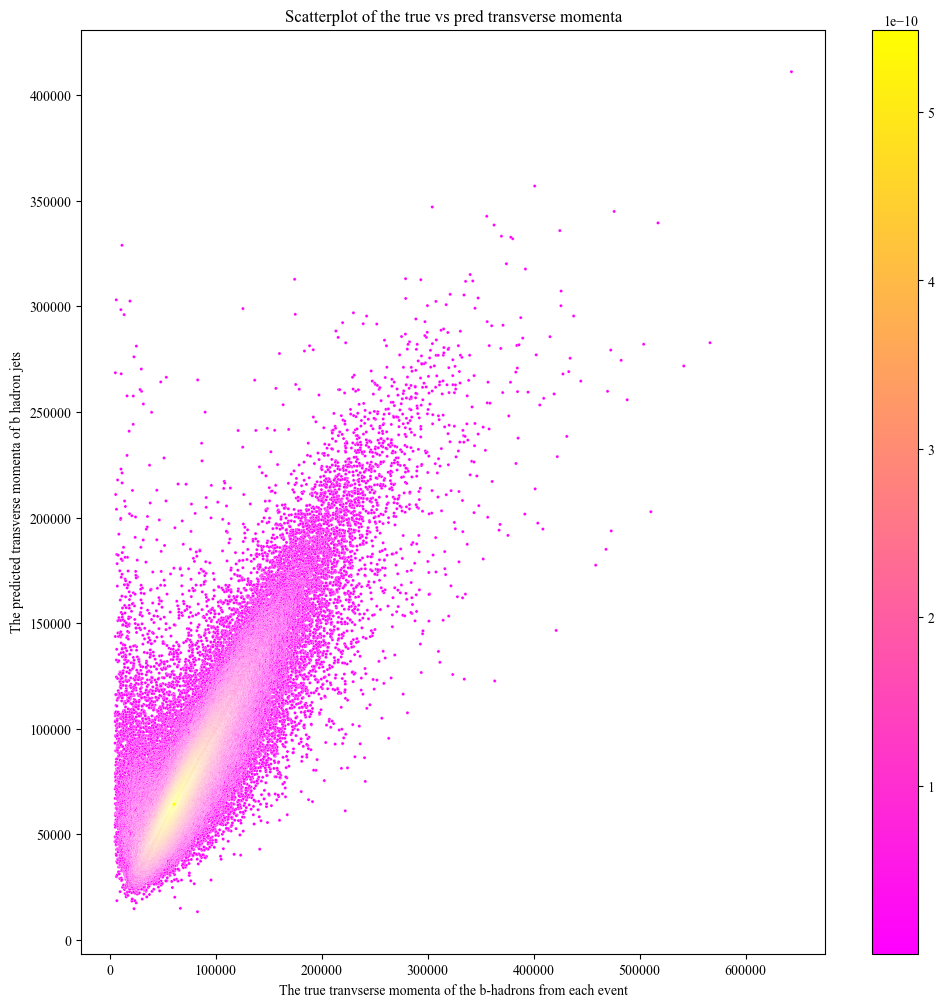

In [156]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,3]*1e6
y = predictions_X[:,3]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred transverse momenta")
ax.set_xlabel("The true tranvserse momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted transverse momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pseudorapidity of b hadron jets')

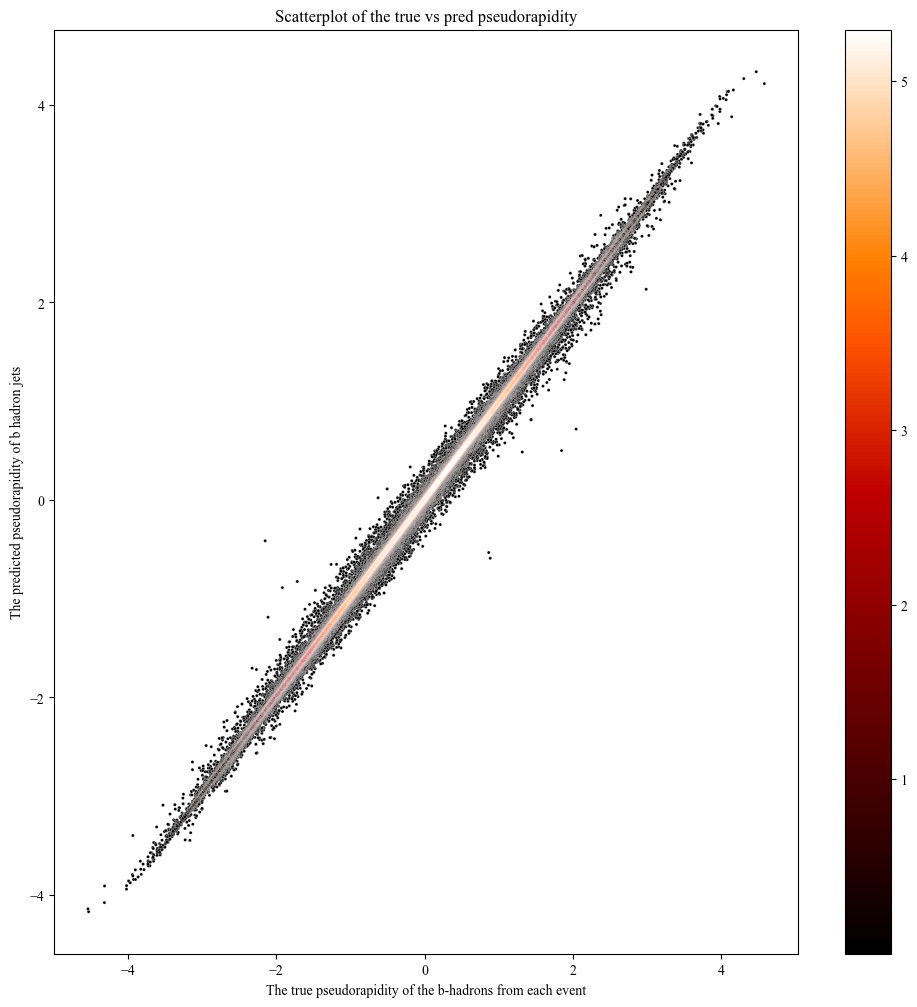

In [157]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,4]
y = predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pseudorapidity")
ax.set_xlabel("The true pseudorapidity of the b-hadrons from each event")
ax.set_ylabel("The predicted pseudorapidity of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted phi of b hadron jets')

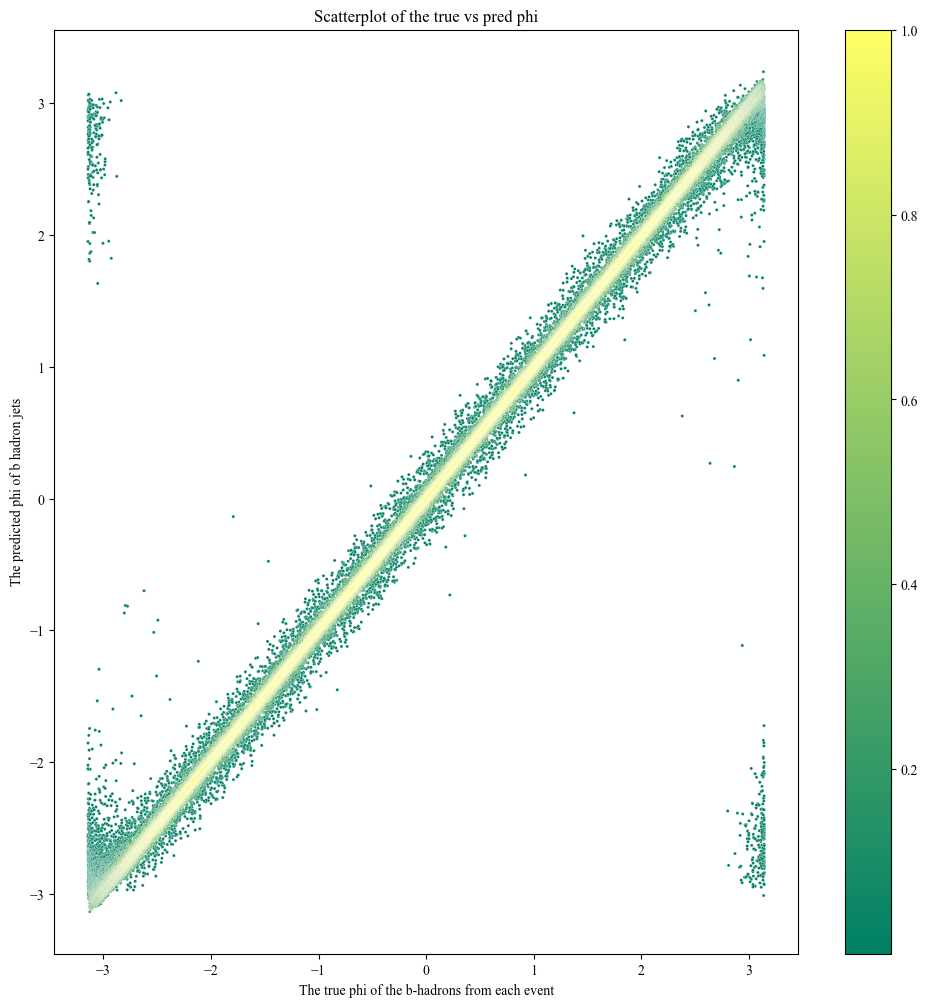

In [158]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,5]
y = predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred phi")
ax.set_xlabel("The true phi of the b-hadrons from each event")
ax.set_ylabel("The predicted phi of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pt fraction of b hadron jets')

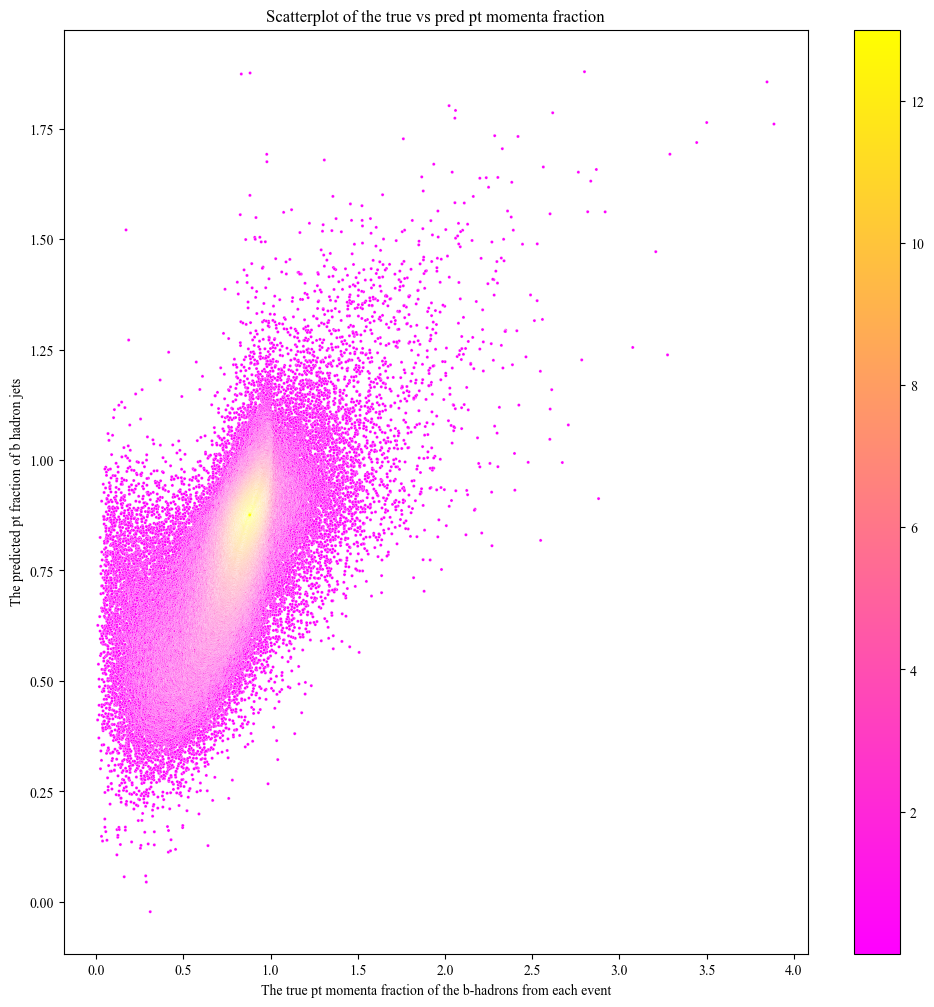

In [159]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,7]
y = predictions_X[:,7]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pt momenta fraction")
ax.set_xlabel("The true pt momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted pt fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted momenta projection of b hadron jets')

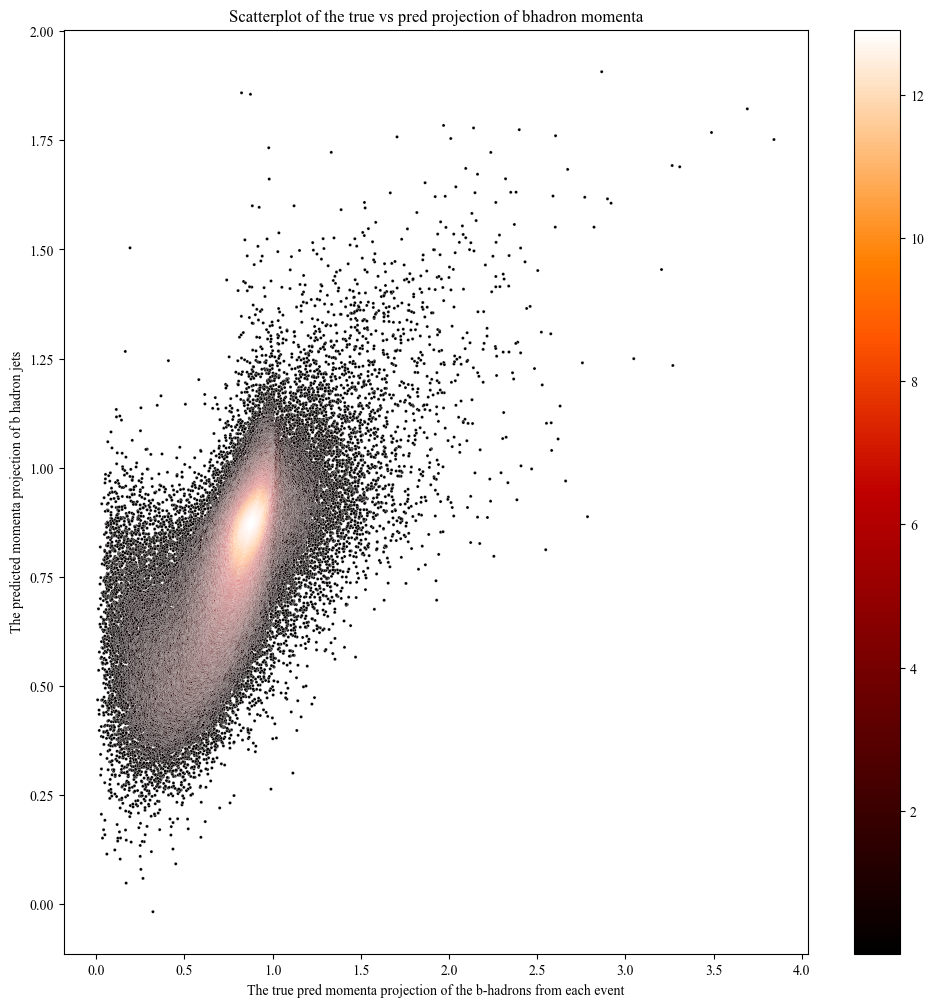

In [160]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,8]
y = predictions_X[:,8]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred projection of bhadron momenta")
ax.set_xlabel("The true pred momenta projection of the b-hadrons from each event")
ax.set_ylabel("The predicted momenta projection of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Bhadron energy of b hadron jets')

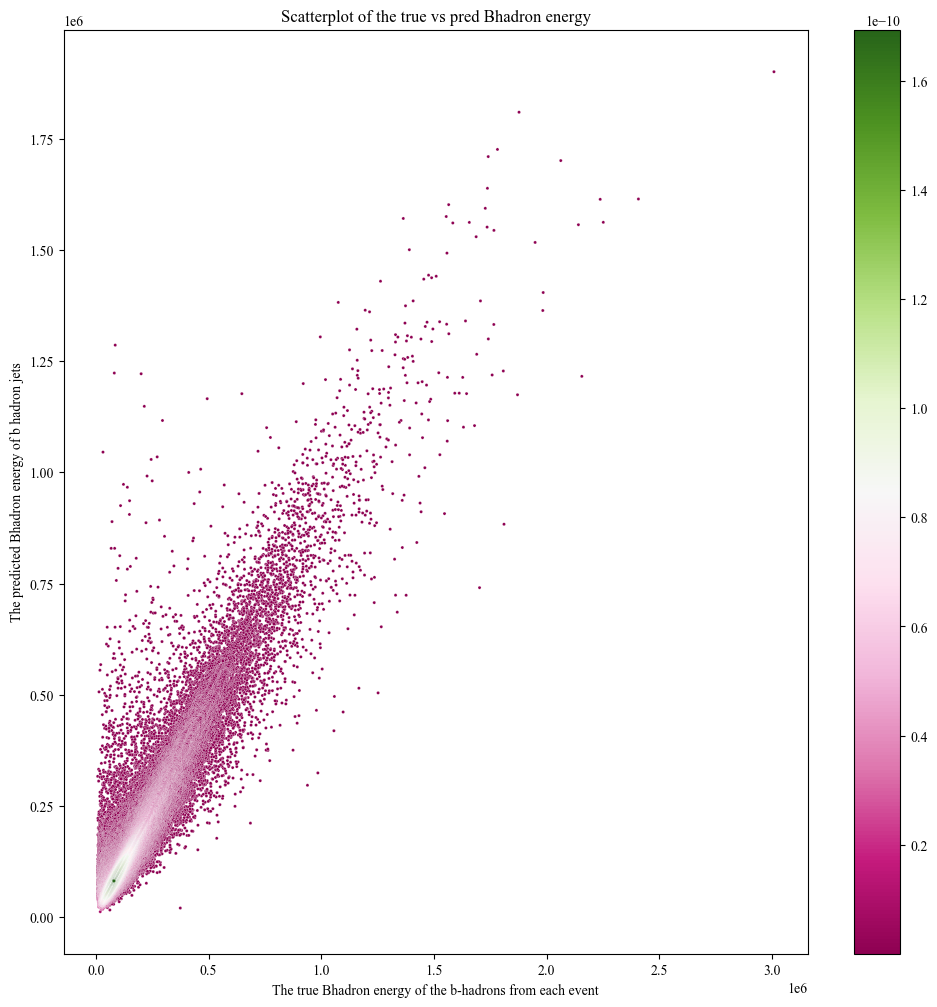

In [161]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,6]*1e6
y = predictions_X[:,6]*1e6
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron energy")
ax.set_xlabel("The true Bhadron energy of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron energy of b hadron jets")

In [162]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1)))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43     41195
           1       0.43      0.57      0.49     41299
           2       0.00      0.00      0.00     14163

    accuracy                           0.43     96657
   macro avg       0.28      0.33      0.31     96657
weighted avg       0.36      0.43      0.39     96657



/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [165]:
DeepSetProjector.save_weights("/home/physics/phujdj/WeightsSaved/MultivariateDeepSets.ckpt")

In [166]:
# Builds the deep neural network
track_layers = [64 for x in range(2)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [64 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector2 = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.0001)

[18, 64, 64]
3


In [167]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [168]:
path = "/home/physics/phujdj/WeightsSaved/MultivariateDeepSets.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

In [169]:
DeepSetProjector.load_weights(latest_DeepNet)

In [171]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((Tracks_input_scaled,b_jets_input_scaled),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 11s - loss: -1.6440e+01 - MultivariateLoss_loss: -1.8054e+01 - MassOutput_loss: 1.0101 - MultivariateLoss_Mean_Squared_Error: 0.0236 - MassOutput_Mean_Squared_Error: 0.2052 - 11s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-16.440420150756836, -18.05400848388672, 1.0100620985031128, 0.023558467626571655, 0.20516695082187653]


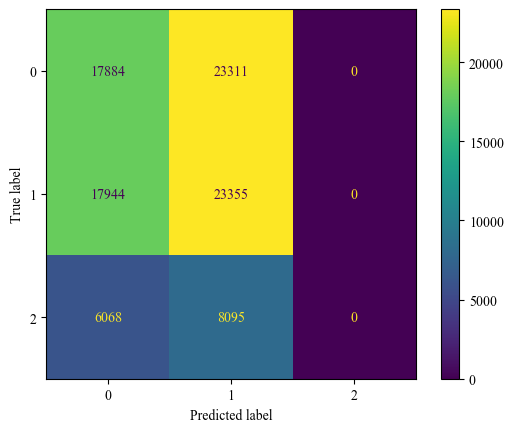

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1))
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [164]:
print(predictions_X[:10,13])
print(bhads_targets_clean[:10,13])

IndexError: index 13 is out of bounds for axis 1 with size 9

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        Predictions_Mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()